<a href="https://www.kaggle.com/code/aerospacer/time-series?scriptVersionId=122692734" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [41]:
#https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/code?datasetId=4538&sortBy=voteCount

#https://www.kaggle.com/code/janiobachmann/s-p-500-time-series-forecasting-with-prophet

#https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm

#https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

#https://www.kaggle.com/code/shreyasajal/pytorch-forecasting-for-time-series-forecasting

In [42]:
!pip install -q yfinance

In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime

In [44]:
yf


<module 'yfinance' from '/opt/conda/lib/python3.7/site-packages/yfinance/__init__.py'>

In [45]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN','TSLA']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN, TSLA]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON","TESLA"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-03-06,198.539993,198.600006,192.300003,193.809998,193.809998,128100100,TESLA
2023-03-07,191.380005,194.199997,186.100006,187.710007,187.710007,148125800,TESLA
2023-03-08,185.039993,186.500000,180.000000,182.000000,182.000000,151897800,TESLA
2023-03-09,180.250000,185.179993,172.509995,172.919998,172.919998,170023800,TESLA
2023-03-10,175.130005,178.289993,168.440002,173.440002,173.440002,191007900,TESLA
2023-03-13,167.460007,177.350006,163.910004,174.479996,174.479996,167790300,TESLA
2023-03-14,177.309998,183.800003,177.139999,183.259995,183.259995,143717900,TESLA
2023-03-15,180.800003,182.339996,176.029999,180.449997,180.449997,145995600,TESLA
2023-03-16,180.369995,185.809998,178.839996,184.130005,184.130005,121136800,TESLA


In [46]:
df.sample(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-05-26,106.050499,108.955254,105.487999,108.295998,108.295998,30288000,GOOGLE
2022-06-23,110.389999,113.000000,107.930000,112.440002,112.440002,64345300,AMAZON
2022-11-11,242.990005,247.990005,241.929993,247.110001,245.799896,34620200,MICROSOFT
2023-02-06,102.930000,103.949997,100.650002,102.180000,102.180000,81945200,AMAZON
2023-03-15,151.190002,153.250000,149.919998,152.990005,152.990005,77167900,APPLE
2022-07-22,265.239990,265.329987,259.070007,260.359985,258.431061,21881300,MICROSOFT
2022-12-15,253.720001,254.199997,247.339996,249.009995,248.387863,35560400,MICROSOFT
2023-03-03,252.190002,255.619995,251.389999,255.289993,255.289993,30741300,MICROSOFT
2023-03-09,153.559998,154.539993,150.229996,150.589996,150.589996,53833600,APPLE


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1250 entries, 2022-03-21 to 2023-03-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1250 non-null   float64
 1   High          1250 non-null   float64
 2   Low           1250 non-null   float64
 3   Close         1250 non-null   float64
 4   Adj Close     1250 non-null   float64
 5   Volume        1250 non-null   int64  
 6   company_name  1250 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.1+ KB


In [48]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1.250000e+03
mean,172.967517,175.899954,169.947594,172.918717,172.536605,6.457980e+07
std,70.383226,71.601505,68.945963,70.215596,69.861279,4.241194e+07
min,82.800003,83.480003,81.430000,81.820000,81.820000,8.567800e+06
25%,113.557503,115.737753,111.865749,113.692499,113.692499,2.962680e+07
50%,148.720001,150.760002,147.024994,148.875000,148.561249,5.815275e+07
75%,239.994999,243.785004,235.482502,240.302502,239.705597,8.413265e+07
max,378.766663,384.290009,362.433319,381.816681,381.816681,3.065906e+08


In [49]:
TSLA.describe()
#We have only 255 records in one year because weekends are not included in the data.

,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,235.408546,241.138680,228.944934,234.837747,234.837747,1.080972e+08
std,63.085559,63.979007,61.906808,62.725632,62.725632,4.975553e+07
min,103.000000,111.750000,101.809998,108.099998,108.099998,4.186470e+07
25%,190.930000,195.769997,185.747501,190.912495,190.912495,7.195425e+07
50%,232.223335,238.985001,224.683334,232.831665,232.831665,9.214500e+07
75%,289.029991,295.099998,280.465012,288.150009,288.150009,1.389887e+08
max,378.766663,384.290009,362.433319,381.816681,381.816681,3.065906e+08


<Figure size 1500x1000 with 0 Axes>

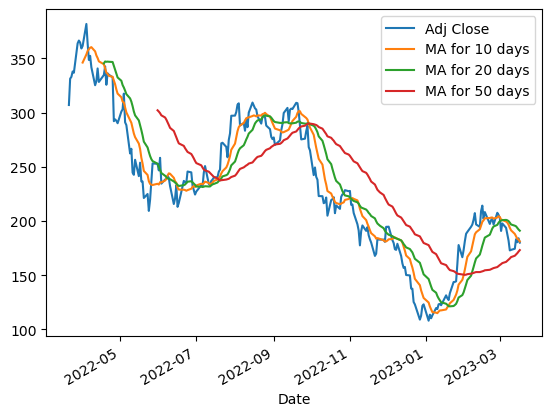

In [50]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)

TSLA[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
#fig.set_title('TESLA')

fig.tight_layout()

In [51]:
# prediction

# Get the stock quote
df = pdr.get_data_yahoo('TSLA', start='2018-01-01', end=datetime.now())
# Show teh data
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000
...,...,...,...,...,...,...
2023-03-13,167.460007,177.350006,163.910004,174.479996,174.479996,167790300
2023-03-14,177.309998,183.800003,177.139999,183.259995,183.259995,143717900
2023-03-15,180.800003,182.339996,176.029999,180.449997,180.449997,145995600


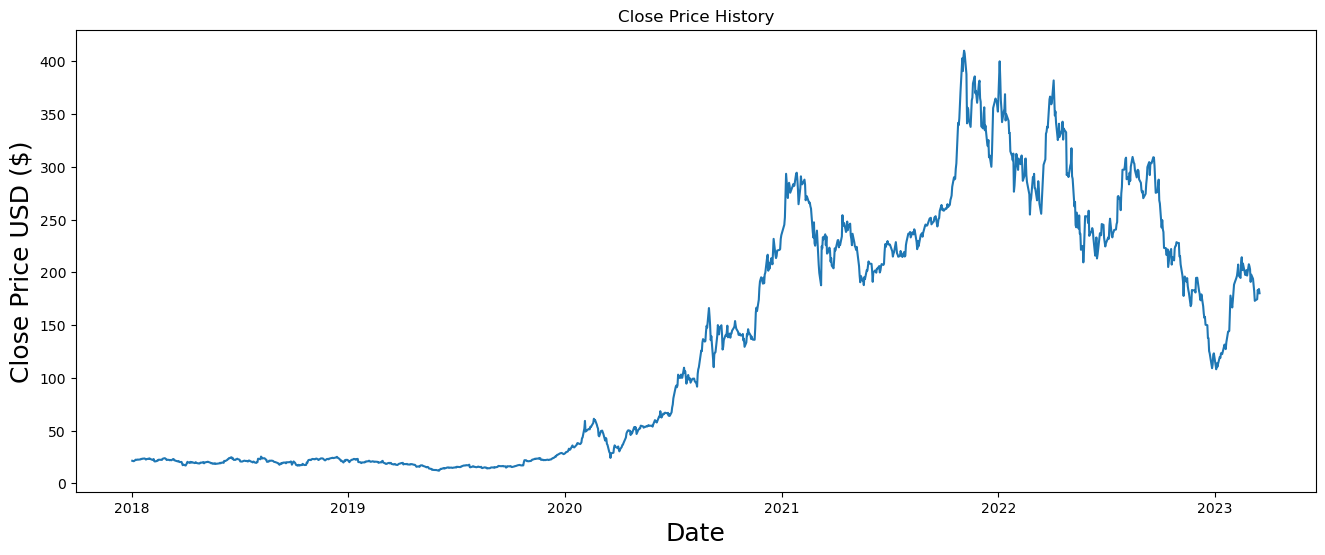

In [52]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [110]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

1049

In [54]:
data.head()

,Close
Date,
2018-01-02,21.368668
2018-01-03,21.150000
2018-01-04,20.974667
2018-01-05,21.105333
2018-01-08,22.427334


In [55]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02370959],
       [0.02316023],
       [0.02271974],
       ...,
       [0.4233726 ],
       [0.43261795],
       [0.42256867]])

In [143]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

array([[[0.02370959],
        [0.02316023],
        [0.02271974],
        ...,
        [0.02097117],
        [0.01678396],
        [0.01319972]],

       [[0.02316023],
        [0.02271974],
        [0.02304801],
        ...,
        [0.01678396],
        [0.01319972],
        [0.01459825]],

       [[0.02271974],
        [0.02304801],
        [0.0263693 ],
        ...,
        [0.01319972],
        [0.01459825],
        [0.01231204]],

       ...,

       [[0.73027742],
        [0.7331415 ],
        [0.73213659],
        ...,
        [0.42839723],
        [0.42178986],
        [0.40726862]],

       [[0.7331415 ],
        [0.73213659],
        [0.74650706],
        ...,
        [0.42178986],
        [0.40726862],
        [0.40576126]],

       [[0.73213659],
        [0.74650706],
        [0.74565288],
        ...,
        [0.40726862],
        [0.40576126],
        [0.41985536]]])

In [99]:
x_train.size()

TypeError: 'int' object is not callable

In [102]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=50, epochs=10)

Epoch 1/10
24/24 [==============================] - 7s 122ms/step - loss: 0.0214
Epoch 2/10
24/24 [==============================] - 3s 118ms/step - loss: 0.0018
Epoch 3/10
24/24 [==============================] - 3s 120ms/step - loss: 0.0014
Epoch 4/10
24/24 [==============================] - 3s 123ms/step - loss: 0.0014
Epoch 5/10
24/24 [==============================] - 3s 128ms/step - loss: 0.0013
Epoch 6/10
24/24 [==============================] - 3s 126ms/step - loss: 0.0013
Epoch 7/10
24/24 [==============================] - 3s 123ms/step - loss: 0.0012
Epoch 8/10
24/24 [==============================] - 3s 120ms/step - loss: 0.0011
Epoch 9/10
24/24 [==============================] - 3s 120ms/step - loss: 0.0011
Epoch 10/10
24/24 [==============================] - 3s 118ms/step - loss: 0.0011


In [109]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

array([[[0.74650706],
        [0.74565288],
        [0.72573013],
        ...,
        [0.40576126],
        [0.41985536],
        [0.39164204]],

       [[0.74565288],
        [0.72573013],
        [0.69505474],
        ...,
        [0.41985536],
        [0.39164204],
        [0.37438238]],

       [[0.72573013],
        [0.69505474],
        [0.66174137],
        ...,
        [0.39164204],
        [0.37438238],
        [0.36395627]],

       ...,

       [[0.36614198],
        [0.34745032],
        [0.34654588],
        ...,
        [0.40576126],
        [0.40837405],
        [0.43043221]],

       [[0.34745032],
        [0.34654588],
        [0.31622222],
        ...,
        [0.40837405],
        [0.43043221],
        [0.4233726 ]],

       [[0.34654588],
        [0.31622222],
        [0.31564439],
        ...,
        [0.43043221],
        [0.4233726 ],
        [0.43261795]]])

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1311 entries, 2018-01-02 to 2023-03-17
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1311 non-null   float64
dtypes: float64(1)
memory usage: 20.5 KB


In [141]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

array([ 21.3686676 ,  21.14999962,  20.9746666 , ..., 180.44999695,
       184.13000488, 180.13000488])

# ARIMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1246
Model:                 ARIMA(5, 1, 0)   Log Likelihood                3273.108
Date:                Sun, 19 Mar 2023   AIC                          -6534.216
Time:                        15:51:17   BIC                          -6503.455
Sample:                             0   HQIC                         -6522.650
                               - 1246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0398      0.019     -2.054      0.040      -0.078      -0.002
ar.L2          0.0125      0.017      0.757      0.449      -0.020       0.045
ar.L3         -0.0012      0.021     -0.054      0.9

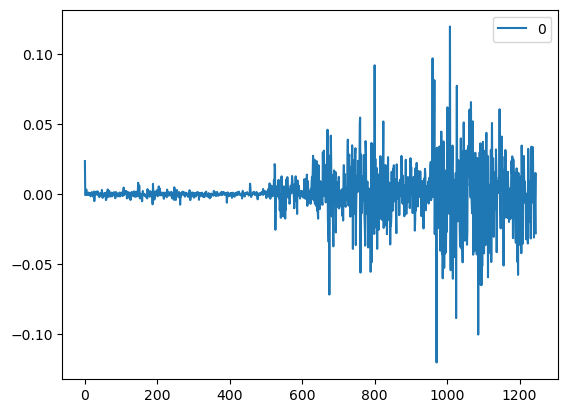

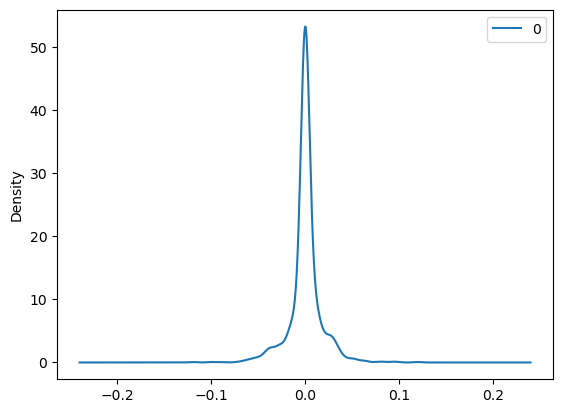

                 0
count  1246.000000
mean      0.000317
std       0.017468
min      -0.120242
25%      -0.002326
50%       0.000169
75%       0.003773
max       0.119935


In [112]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA (train_data, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print (residuals.describe())

In [113]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [114]:
data_arima=series['Close']

,Close
Date,
2018-01-02,21.368668
2018-01-03,21.150000
2018-01-04,20.974667
2018-01-05,21.105333
2018-01-08,22.427334
...,...
2023-03-13,174.479996
2023-03-14,183.259995
2023-03-15,180.449997


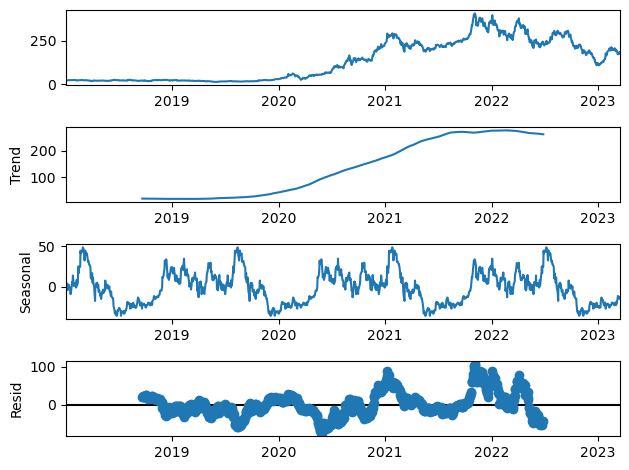

In [115]:
result = seasonal_decompose(data, model='additive',period=365) # The frequncy is daily
figure = result.plot()

In [79]:
#valid = np.reshape(valid.Close.values, (valid.shape[0], valid.Close.shape[0], 1))

65

In [116]:
valid

,Close,Predictions
Date,,
2022-12-13,160.949997,186.222412
2022-12-14,156.800003,183.373718
2022-12-15,157.669998,179.856018
2022-12-16,150.229996,176.272247
2022-12-19,149.869995,172.299866
...,...,...
2023-03-13,174.479996,194.356430
2023-03-14,183.259995,190.713959
2023-03-15,180.449997,188.245575


In [91]:
valid.Close

Date
2022-12-13    160.949997
2022-12-14    156.800003
2022-12-15    157.669998
2022-12-16    150.229996
2022-12-19    149.869995
                 ...    
2023-03-13    174.479996
2023-03-14    183.259995
2023-03-15    180.449997
2023-03-16    184.130005
2023-03-17    180.130005
Name: Close, Length: 65, dtype: float64

In [90]:
valid['Close']

Date
2022-12-13    160.949997
2022-12-14    156.800003
2022-12-15    157.669998
2022-12-16    150.229996
2022-12-19    149.869995
                 ...    
2023-03-13    174.479996
2023-03-14    183.259995
2023-03-15    180.449997
2023-03-16    184.130005
2023-03-17    180.130005
Name: Close, Length: 65, dtype: float64

In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1246 entries, 2018-01-02 to 2022-12-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1246 non-null   float64
dtypes: float64(1)
memory usage: 19.5 KB


In [93]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2022-12-13 to 2023-03-17
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        65 non-null     float64
 1   Predictions  65 non-null     float32
dtypes: float32(1), float64(1)
memory usage: 1.3 KB


In [ ]:
train = train
valid = valid.Close


history = [x for x in train]
predictions = list('train')

# walk-forward validation
for t in range(len(valid)):
    model = ARIMA(history, order=(3,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [119]:
# evaluate forecasts
rolling_mse = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % rolling_mse)

NameError: name 'mean_squared_error' is not defined

In [136]:
train = df_train['Close'].values
test = df_valid['Close'].values

array([nan, nan, nan, ..., nan, nan, nan])

In [142]:
train = data[:training_data_len]
valid = data[training_data_len:]

In [133]:
stocks_data=data
df_train = stocks_data[stocks_data.Date < 2021]
df_valid = stocks_data[stocks_data.Date >= 2021]

AttributeError: 'DataFrame' object has no attribute 'Date'

In [130]:
train = df_train['Close'].values
test = df_valid['Close'].values

array([nan, nan, nan, ..., nan, nan, nan])

In [145]:
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(valid)):
    model = ARIMA(history, order=(3,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''